In [10]:
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import shutil


# 클래스 균형 확인 코드
def check_class_balance(class_target_list):
    cate = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    for train_labels in tqdm(class_target_list): # 1 txt file
        with open(train_labels, 'r', encoding='utf-8') as f:
            label = f.readlines() # 1 txt file labels
            for lab in label: # 1 line, in 1 txt file
                lab = lab.split(' ')
                cls = int(lab[0])

                if cls == 0:
                    cate[0] += 1
                elif cls == 1:
                    cate[1] += 1
                elif cls == 2:
                    cate[2] += 1
                elif cls == 3:
                    cate[3] += 1
                elif cls == 4:
                    cate[4] += 1
                elif cls == 5:
                    cate[5] += 1
                elif cls == 6:
                    cate[6] += 1
                elif cls == 7:
                    cate[7] += 1
                elif cls == 8:
                    cate[8] += 1
                elif cls == 9:
                    cate[9] += 1
                elif cls == 10:
                    cate[10] += 1
                elif cls == 11:
                    cate[11] += 1
                elif cls == 12:
                    cate[12] += 1
                elif cls == 13:
                    cate[13] += 1 

    result_cate = cate
    print(result_cate)

    X = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
    Y = np.array(result_cate)

    ax = sns.barplot(X,Y, order=X)
    for p, q in zip(ax.patches, Y):
        ax.text(p.get_x()+p.get_width()/2.,
            p.get_height()*(1.01),
            "{}".format(q),
            ha = 'center'  )

    plt.show()
    
    
def yolobbox2bbox(x, y, w, h, w_t, h_t):
    x1, y1 = (x - (w / 2.0)) * w_t, (y - (h / 2.0)) * h_t
    x2, y2 = (x + (w / 2.0)) * w_t, (y + (h / 2.0)) * h_t
    x1 = round(x1, 1)
    y1 = round(y1, 1)
    x2 = round(x2, 1)
    y2 = round(y2, 1)
    
    return (x1, y1, x2, y2)


def bbox2yolobbox(x1, y1, x2, y2, w_t, h_t):
    x = round((x2 + x1) / (2 * w_t), 6)
    y = round((y2 + y1) / (2 * h_t), 6)
    w = round((x2 - x1) / w_t, 6)
    h = round((y2 - y1) / h_t, 6)
    
    return (x, y, w, h)


def find_class_images(target_class, all_train_label_list):
    target_class = target_class
    num_class_target = 0
    class_target_list = []

    for train_labels in tqdm(all_train_label_list): # 1 txt file
        with open(train_labels, 'r', encoding='utf-8') as f:
            label = f.readlines() # 1 txt file labels
            for lab in label: # 1 line, in 1 txt file
                lab = lab.split(' ')
                cls, x, y, w, h = int(lab[0]), float(lab[1]), float(lab[2]), float(lab[3]), float(lab[4])

                if cls == target_class:
                    num_class_target += 1

                    class_target_list.append(train_labels)

    print("Class Num:", num_class_target)
    print("Image Num:", len(set(class_target_list)))
    
    return class_target_list


# Img Aug Total Code
def aug_images(img_path, txt_path, output_img_path, output_txt_path):
    img_array = np.fromfile(img_path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    input_img = img[np.newaxis, :, :, :]

    txts = np.loadtxt(txt_path, dtype = str, delimiter = ' ').astype(float)
    if txts.ndim == 1:
        txts = txts[np.newaxis, :]
    
    labels = []
    for i, txt in enumerate(txts):
        x1, y1, x2, y2 = yolobbox2bbox(txt[1], txt[2], txt[3], txt[4], 1920, 1080)
        input_label = [int(txt[0]), x1, y1, x2, y2]
        labels.append(input_label)
    
    bbox = []
    for label in labels:
        bbox.append(ia.BoundingBox(x1 = label[1], y1 = label[2], x2 = label[3], y2 = label[4], label = label[0]))

    seq = iaa.Sequential([
        iaa.Affine(
            scale={"x": (0.5, 0.7), "y": (0.5, 0.7)},
            rotate = (-15, 15)
        ),
        iaa.AdditiveGaussianNoise(scale = (0.05*255, 0.10*255)),
        iaa.GaussianBlur((0, 1.0)),
        iaa.PerspectiveTransform(scale=(0.01, 0.02))
    ])

    output_img, output_bbox = seq(images = input_img, bounding_boxes = bbox)
    output_img = np.squeeze(output_img, axis=0)

    result, encoded_img = cv2.imencode('.png', output_img)
    
    if result:
        with open(output_img_path, mode='w+b') as f:
            encoded_img.tofile(f)

    with open(output_txt_path, 'w', encoding='utf-8') as f:
        for bbox in output_bbox:
            x, y, w, h = bbox2yolobbox(bbox.x1, bbox.y1, bbox.x2, bbox.y2, 1920, 1080)

            line = str(bbox.label) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n'
            f.write(line)
            

if __name__ == "__main__":
    # Directory Copy
    shutil.copytree("../dataset/train-001", "../dataset/train-001-aug-re")
    train_label_list = glob("../dataset/train-001-aug-re/labels/*.txt")

    class12_target_list = find_class_images(12, train_label_list)
    class10_target_list = find_class_images(10, train_label_list)
    class08_target_list = find_class_images(8, train_label_list)
    class03_target_list = find_class_images(3, train_label_list)
    class06_target_list = find_class_images(6, train_label_list)
    class02_target_list = find_class_images(2, train_label_list)
    
    # Class 12(x 50), 10(x 10), 8(x 10), 3(x 5), 6(x 2), 2(x 2)
    class12_target_set = set(class12_target_list)
    class10_target_set = set(class10_target_list)
    class08_target_set = set(class08_target_list)
    class03_target_set = set(class03_target_list)
    class06_target_set = set(class06_target_list)
    class02_target_set = set(class02_target_list)
    
    # Seed Setting
    ia.seed(42)
    
    for i in tqdm(range(50)):
        for path in class12_target_set:
            txt_path = path
            img_path = path.replace("labels", "images").replace("txt", "png")

            aug_images(img_path, txt_path, img_path[:-4] + "_aug" + str(i) + ".png", txt_path[:-4] + "_aug" + str(i) + ".txt")

    for i in tqdm(range(10)):
        for path in class10_target_set:
            txt_path = path
            img_path = path.replace("labels", "images").replace("txt", "png")

            aug_images(img_path, txt_path, img_path[:-4] + "_aug" + str(i) + ".png", txt_path[:-4] + "_aug" + str(i) + ".txt")

    for i in tqdm(range(10)):
        for path in class08_target_set:
            txt_path = path
            img_path = path.replace("labels", "images").replace("txt", "png")

            aug_images(img_path, txt_path, img_path[:-4] + "_aug" + str(i) + ".png", txt_path[:-4] + "_aug" + str(i) + ".txt")

    for i in tqdm(range(5)):
        for path in class03_target_set:
            txt_path = path
            img_path = path.replace("labels", "images").replace("txt", "png")

            aug_images(img_path, txt_path, img_path[:-4] + "_aug" + str(i) + ".png", txt_path[:-4] + "_aug" + str(i) + ".txt")

    for i in tqdm(range(2)):
        for path in class06_target_set:
            txt_path = path
            img_path = path.replace("labels", "images").replace("txt", "png")

            aug_images(img_path, txt_path, img_path[:-4] + "_aug" + str(i) + ".png", txt_path[:-4] + "_aug" + str(i) + ".txt")
            
    all_train_label_list = glob("../dataset/train-001-aug-re/labels/*.txt")
    check_class_balance(all_train_label_list)
    print("Total Image Number: ", len(all_train_label_list)) 
    print("Data Augmentation Finished!")

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: '../dataset/train-001-aug-re'

In [11]:
import cv2
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import shutil


# 클래스 균형 확인 코드
def check_class_balance(class_target_list):
    cate = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    for train_labels in tqdm(class_target_list): # 1 txt file
        with open(train_labels, 'r', encoding='utf-8') as f:
            label = f.readlines() # 1 txt file labels
            for lab in label: # 1 line, in 1 txt file
                lab = lab.split(' ')
                cls = int(lab[0])

                if cls == 0:
                    cate[0] += 1
                elif cls == 1:
                    cate[1] += 1
                elif cls == 2:
                    cate[2] += 1
                elif cls == 3:
                    cate[3] += 1
                elif cls == 4:
                    cate[4] += 1
                elif cls == 5:
                    cate[5] += 1
                elif cls == 6:
                    cate[6] += 1
                elif cls == 7:
                    cate[7] += 1
                elif cls == 8:
                    cate[8] += 1
                elif cls == 9:
                    cate[9] += 1
                elif cls == 10:
                    cate[10] += 1
                elif cls == 11:
                    cate[11] += 1
                elif cls == 12:
                    cate[12] += 1
                elif cls == 13:
                    cate[13] += 1 

    result_cate = cate
    print(result_cate)

    X = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
    Y = np.array(result_cate)

    ax = sns.barplot(X,Y, order=X)
    for p, q in zip(ax.patches, Y):
        ax.text(p.get_x()+p.get_width()/2.,
            p.get_height()*(1.01),
            "{}".format(q),
            ha = 'center'  )

    plt.show()

In [6]:
%cd yolor

C:\Users\user\Desktop\jh\yolor


In [8]:
!python augmentation.py

Class Num: 64
Image Num: 55
Class Num: 356
Image Num: 129
Class Num: 496
Image Num: 454
Class Num: 902
Image Num: 412
Class Num: 1564
Image Num: 1431
Class Num: 4581
Image Num: 4068
[85833, 42403, 6703, 5592, 1230, 5082, 4772, 32713, 5456, 4757, 3916, 3095, 182, 10922]
Total Image Number:  35305
Data Augmentation Finished!



 92%|#########1| 22599/24650 [00:35<00:03, 633.22it/s]


100%|##########| 24650/24650 [00:38<00:00, 641.34it/s]

100%|##########| 24650/24650 [00:00<00:00, 34748.10it/s]

100%|##########| 24650/24650 [00:00<00:00, 34079.68it/s]

100%|##########| 24650/24650 [00:00<00:00, 35450.88it/s]

100%|##########| 24650/24650 [00:00<00:00, 33966.10it/s]

100%|##########| 24650/24650 [00:00<00:00, 36328.51it/s]

100%|##########| 1/1 [00:10<00:00, 10.77s/it]

100%|##########| 10/10 [04:27<00:00, 26.76s/it]

100%|##########| 10/10 [15:11<00:00, 91.15s/it]

100%|##########| 5/5 [07:07<00:00, 85.49s/it]

100%|##########| 2/2 [09:24<00:00, 282.39s/it]

100%|##########| 35305/35305 [00:17<00:00, 2050.02it/s]


In [1]:
all_train_label_list = glob("../dataset/train-001-aug-re/labels/*.txt")
print(len(all_train_label_list))

NameError: name 'glob' is not defined

In [ ]:
all_train_label_list = glob("../dataset/train-001-aug-re/labels/*.txt")
check_class_balance(all_train_label_list)
print("Total Image Number: ", len(all_train_label_list))

In [ ]:
# 실행???
for i in tqdm(range(1)):
    for path in class02_target_set:
        txt_path = path
        img_path = path.replace("labels", "images").replace("txt", "png")

        aug_images(img_path, txt_path, img_path[:-4] + "_aug" + str(i) + ".png", txt_path[:-4] + "_aug" + str(i) + ".txt")

100%|█████████████████████████████████████████████████████████████████████████| 37946/37946 [00:01<00:00, 29428.41it/s]
C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[93025, 45561, 9059, 5592, 1230, 5082, 4772, 38320, 5696, 4757, 3916, 3095, 3264, 11216]


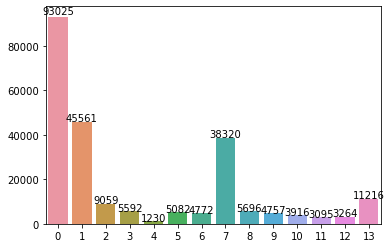

37946


In [30]:
all_train_label_list = glob("../dataset/train-001-aug-re/labels/*.txt")
check_class_balance(all_train_label_list)
print("Total Image Number: ", len(all_train_label_list))